In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class CustomNode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomNode, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class CustomBlock(nn.Module):
    def __init__(self, encoding, in_channels, out_channels):
        super(CustomBlock, self).__init__()

        # Node 0: default initial node
        self.default_initial_node = CustomNode(in_channels, out_channels)

        # Decode the encoding into individual node connections
        self.node_encodings = []
        idx = 0
        k = 1  # Start with the 1st bit for node 2
        while idx < len(encoding):
            self.node_encodings.append(encoding[idx:idx+k])
            idx += k
            k += 1

        # Adding an extra node for node 1 (that is not encoded)
        self.layers = nn.ModuleList([CustomNode(out_channels, out_channels) for _ in range(len(self.node_encodings) + 1)])

    def forward(self, x):
        outputs = [self.default_initial_node(x)]

        # Processing for node 1
        outputs.append(self.layers[0](outputs[0]))

        for idx, layer in enumerate(self.layers[1:], start=1):
            # Get inputs for this node based on encoding
            node_inputs = [outputs[j] for j, val in enumerate(self.node_encodings[idx-1]) if val == '1']

            # If no inputs from previous nodes, take from default initial node
            if len(node_inputs) == 0:
                node_inputs.append(outputs[0])

            node_input = sum(node_inputs)
            node_output = layer(node_input)
            outputs.append(node_output)

        return outputs[-1]  # Return the output of the last node

class CustomCNN(nn.Module):
    def __init__(self, encoding):
        super(CustomCNN, self).__init__()

        encoding_length = len(encoding)
        half_encoding_length = encoding_length // 2

        self.block1 = CustomBlock(encoding[:half_encoding_length], in_channels=3, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2 = CustomBlock(encoding[half_encoding_length:], in_channels=64, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Final layer
        self.fc = nn.Linear(128 * 8 * 8, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Biến toàn cục để xác định nếu có GPU có sẵn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chuẩn bị transform và tải CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class GeneticAlgorithm:
    def __init__(self, num_individuals, chromosome_length, num_generations, p_C, p_M, r_C, r_M):
        self.num_individuals = num_individuals
        self.chromosome_length = chromosome_length
        self.num_generations = num_generations
        self.p_C = p_C
        self.p_M = p_M
        self.r_C = r_C
        self.r_M = r_M
        self.fitness_cache = {}
        self.all_generations_fitness = []
        self.population = self.initialize_population()

    # Khởi tạo quần thể thỏa mãn phân phối Bernoulli 0.5
    def initialize_population(self):
        # Sử dụng phân phối Bernoulli với p = 0.5
        return np.random.choice([0, 1], size=(self.num_individuals, self.chromosome_length), p=[0.5, 0.5])

    # Hàm thích nghi
    def fitness(self, individual):
        key = ''.join(map(str, individual))
        if key in self.fitness_cache:
            return self.fitness_cache[key]

        encoding = key
        model = CustomCNN(encoding).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(5):  # training for 5 epochs
            for data in trainloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        correct = 0
        total = 0
        with torch.no_grad():
            for data in trainloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        self.fitness_cache[key] = accuracy
        return accuracy

    # Hàm chọn cha mẹ theo Roulette Wheel
    def parent_selection(self, fitnesses):
        total_fitness = sum(fitnesses)
        selection_probs = fitnesses / total_fitness
        selected_index = np.random.choice(range(self.num_individuals), p=selection_probs)
        return selected_index

    # Hàm lai ghép
    def crossover(self, parent1, parent2):
        if np.random.rand() < self.p_C:
            # Chọn ngẫu nhiên điểm cắt đầu tiên
            point1 = np.random.randint(1, len(parent1) - self.r_C + 1)

            # Điểm cắt thứ hai dựa trên r_C
            point2 = point1 + self.r_C

            # Tạo con cái bằng cách tráo đổi phần giữa hai điểm cắt
            offspring1 = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
            offspring2 = np.concatenate((parent2[:point1], parent1[point1:point2], parent2[point2:]))

            return offspring1, offspring2
        return parent1.copy(), parent2.copy()

    # Hàm đột biến
    def mutate(self, individual):
        if np.random.rand() < self.p_M:
            # Chọn ngẫu nhiên điểm bắt đầu cho chuỗi đảo
            start_point = np.random.randint(0, len(individual) - self.r_M + 1)

            # Đảo chuỗi dài r_M từ điểm bắt đầu
            for i in range(start_point, start_point + self.r_M):
                individual[i] = 1 - individual[i]
        return individual

    # Quá trình di truyền
    def execute(self):
        for generation in range(self.num_generations):
            fitnesses = np.array([self.fitness(ind) for ind in self.population])

            self.all_generations_fitness.append(fitnesses)

            print(f"Generation {generation + 1}")
            for ind, fit in zip(self.population, fitnesses):
                print(f"{ind} - Accuracy: {fit:.2f}%")

            # Tạo quần thể mới thông qua lai ghép và đột biến
            new_population = []

            while len(new_population) < self.num_individuals:
                parent_index1 = self.parent_selection(fitnesses)
                parent_index2 = self.parent_selection(fitnesses)

                offspring1, offspring2 = self.crossover(self.population[parent_index1], self.population[parent_index2])

                self.mutate(offspring1)
                self.mutate(offspring2)

                # Tránh trùng lặp cá thể
                if not any(np.array_equal(offspring1, ind) for ind in new_population):
                    new_population.append(offspring1)
                if not any(np.array_equal(offspring2, ind) for ind in new_population) and len(new_population) < self.num_individuals:
                    new_population.append(offspring2)

            # Bổ sung cá thể con vào quần thể và chọn ra các cá thể tốt nhất cho thế hệ tiếp theo
            combined_population = np.concatenate((self.population, new_population))
            combined_fitnesses = np.array([self.fitness(ind) for ind in combined_population])
            top_indices = np.argsort(combined_fitnesses)[-self.num_individuals:]
            self.population = combined_population[top_indices]

ga = GeneticAlgorithm(num_individuals=7, chromosome_length=20, num_generations=10, p_C=0.7, p_M=0.2, r_C=4, r_M=2)
ga.execute()

Generation 1
[0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0] - Accuracy: 88.41%
[0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1] - Accuracy: 89.65%
[0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0] - Accuracy: 88.48%
[1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1] - Accuracy: 89.17%
[0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0] - Accuracy: 89.45%
[1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0] - Accuracy: 89.21%
[1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1] - Accuracy: 87.58%
Generation 2
[1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0] - Accuracy: 89.21%
[1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1] - Accuracy: 89.43%
[0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0] - Accuracy: 89.45%
[0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1] - Accuracy: 89.65%
[0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1] - Accuracy: 89.65%
[0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1] - Accuracy: 89.85%
[0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1] - Accuracy: 90.04%
Generation 3
[0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1] - Accuracy: 89.65%
[0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1] - Ac

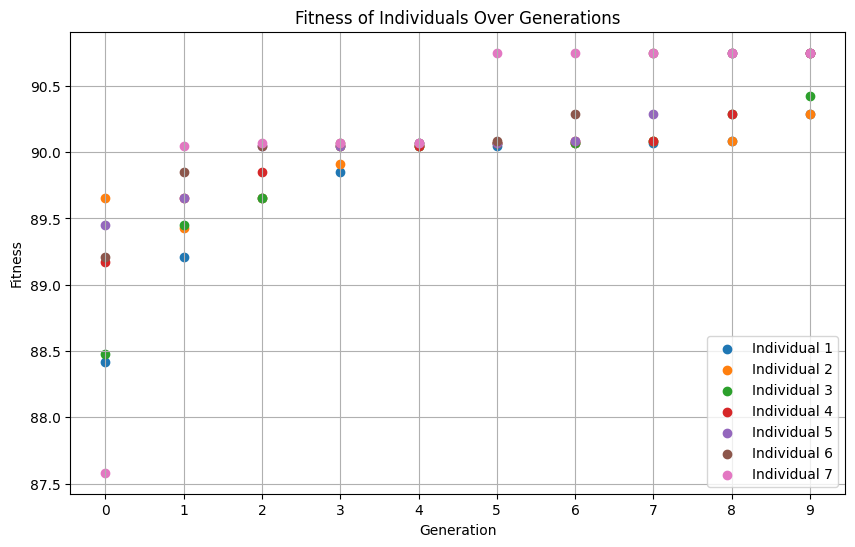

In [7]:
import matplotlib.pyplot as plt

fitness_data = ga.all_generations_fitness

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
num_individuals = 7
num_generations = 10

for i in range(num_individuals):
    plt.scatter(range(num_generations), [gen[i] for gen in fitness_data], label=f'Individual {i+1}')

plt.title('Fitness of Individuals Over Generations')
plt.xlabel('Generation')
plt.xticks(np.arange(num_generations))
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()